# Generate MNIST dataset on a black canvas

## Generate the artificial dataset

### Imports

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.7.0


### Parameters

In [ ]:
NEW_IMG_SIZE = 200
BATCH_SIZE = 32
MAX_DATA = 1000
N_BOXES = 4

### Visualization Utilities

These functions are used to draw bounding boxes around the digits.

In [ ]:
use_normalized_coordinates = True

def draw_bounding_boxes_on_image_array(image,
                                       boxes,
                                       color=[],
                                       thickness=1,
                                       display_str_list=()):
  """Draws bounding boxes on image (numpy array).
  Args:
    image: a numpy array object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list_list: a list of strings for each bounding box.
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  image_pil = PIL.Image.fromarray(image)
  rgbimg = PIL.Image.new("RGBA", image_pil.size)
  rgbimg.paste(image_pil)
  draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness,
                               display_str_list)
  return np.array(rgbimg)
  

def draw_bounding_boxes_on_image(image,
                                 boxes,
                                 color=[],
                                 thickness=1,
                                 display_str_list=()):
  """Draws bounding boxes on image.
  Args:
    image: a PIL.Image object.
    boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
           The coordinates are in normalized format between [0, 1].
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: a list of strings for each bounding box.
                           
  Raises:
    ValueError: if boxes is not a [N, 4] array
  """
  boxes_shape = boxes.shape
  if not boxes_shape:
    return
  if len(boxes_shape) != 2 or boxes_shape[1] != 4:
    raise ValueError('Input must be of size [N, 4]')
  for i in range(boxes_shape[0]):
    draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3], boxes[i, 2],  thickness)
        
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=1,
                               display_str=None,
                               use_normalized_coordinates=True):
  """Adds a bounding box to an image.
  Bounding box coordinates can be specified in either absolute (pixel) or
  normalized coordinates by setting the use_normalized_coordinates argument.
  Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: string to display in box
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
  """
  draw = PIL.ImageDraw.Draw(image)
  NEW_IMG_SIZE, NEW_IMG_SIZE = image.size
  if use_normalized_coordinates:
    (left, right, top, bottom) = (xmin * NEW_IMG_SIZE, xmax * NEW_IMG_SIZE,
                                  ymin * NEW_IMG_SIZE, ymax * NEW_IMG_SIZE)
  else:
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
  draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
  


These utilities are used to visualize the data and predictions.

In [ ]:
"""
This cell contains helper functions used for visualization
and downloads only. 

You can skip reading it, as there is very
little Keras or Tensorflow related code here.
"""

# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(digits, bboxes, title, n_images=10):

  digits = digits[:n_images]
  bboxes = bboxes[:n_images]

  n_digits = digits * 255.0
  n_digits = n_digits.reshape(n_images, NEW_IMG_SIZE, NEW_IMG_SIZE)
  fig = plt.figure(figsize=(n_images, 4))
  plt.title(title)
  
  
  for i in range(n_images):
    ax = fig.add_subplot(1, n_images, i+1)
    img_to_draw = draw_bounding_boxes_on_image_array(image=n_digits[i], boxes=bboxes[i], color=['red'], display_str_list=["true"])
    
    plt.imshow(img_to_draw)
  plt.yticks([])
  plt.xticks([])

# utility to display training and validation curves
def plot_metrics(history, metric_name, title, ylim=5):
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(history.history[metric_name],color='blue',label=metric_name)
  plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

### Loading and Preprocessing the Dataset

Define some helper functions that will pre-process your data:
- `read_image_tfds`: randomly overlays the "digit" image on top of a larger canvas.
- `get_training_dataset`: loads data and splits it to get the training set.
- `get_validation_dataset`: loads and splits the data to get the validation set.

In [ ]:

'''
Transforms each image in dataset by pasting it on a NEW_IMG_SIZExNEW_IMG_SIZE canvas at random locations.
'''
def draw_on_canvas(images_numpy):
    imgs = []
    bboxes = []
    for image_numpy in images_numpy:
        image = tf.convert_to_tensor(image_numpy)
        xmin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        ymin = tf.random.uniform((), 0 , NEW_IMG_SIZE - 28 - 3, dtype=tf.int32)
        image = tf.reshape(image, (28,28,1,))
        image = tf.image.pad_to_bounding_box(image, ymin, xmin, NEW_IMG_SIZE, NEW_IMG_SIZE)
    
        image = tf.cast(image, tf.float32)/255.0
    
    
    #image += tf.random.normal(shape=image.shape) * 0.5
        xmin = tf.cast(xmin, tf.float32)
        ymin = tf.cast(ymin, tf.float32)
   
        xmax = (xmin + 28) / NEW_IMG_SIZE
        ymax = (ymin + 28) / NEW_IMG_SIZE
        xmin = xmin / NEW_IMG_SIZE
        ymin = ymin / NEW_IMG_SIZE

        imgs.append(image)
        box = np.array([xmin, ymin, xmax, ymax])
        bboxes.append(box)


    return (sum(imgs)).numpy(), np.array(bboxes)


In [ ]:
def get_train_test(max_data=100):
    ds_train = tfds.load(name="mnist", split="train")
    ds_numpy = tfds.as_numpy(ds_train)
    train_images = []
    train_labels = []
    for i, data in enumerate(ds_numpy):
        if i > max_data:
            break
        train_images.append(data["image"])
        train_labels.append(data["labels"])
    
    ds_test = tfds.load(name="mnist", split="test")
    ds_numpy = tfds.as_numpy(ds_test)
    test_images = []
    test_labels = []
    for i, data in enumerate(ds_numpy):
        if i > max_data:
            break
        test_images.append(data["image"])
        test_labels.append(data["labels"])
    
    return np.array(train_images), np.array(test_images), np.array(train_labels), np.array(test_labels)
    
def generate_bboxes(ds_numpy, labels, max_data=100):
    images = []
    bboxes = []
    labels = []

    for i in range(max_data):
        idx = np.random.choice(MAX_DATA, N_BOXES)
        imgs = ds_numpy[idx]
        label = labels[idx]
        img, boxes = draw_on_canvas(imgs)

        images.append(img)
        bboxes.append(boxes)
    return np.array(images), np.array(bboxes), np.array()

In [ ]:
train_images, test_images = get_train_test(max_data=MAX_DATA)
train_images.shape, test_images.shape



local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


((1001, 28, 28, 1), (1001, 28, 28, 1))

In [ ]:
train_images_wcanvac, train_bboxes = generate_bboxes(train_images, max_data=MAX_DATA)
test_images_wcanvac, test_bboxes = generate_bboxes(test_images, max_data=100)
train_images_wcanvac.shape, train_bboxes.shape, test_images_wcanvac.shape, test_bboxes.shape

((1000, 200, 200, 1), (1000, 4, 4), (100, 200, 200, 1), (100, 4, 4))

### Visualize Data

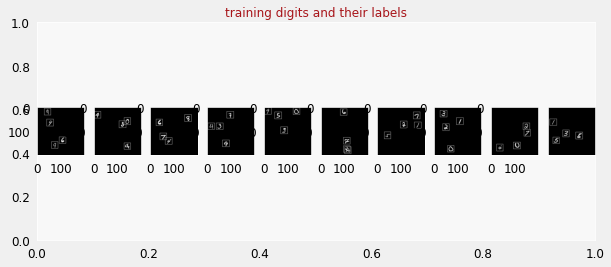

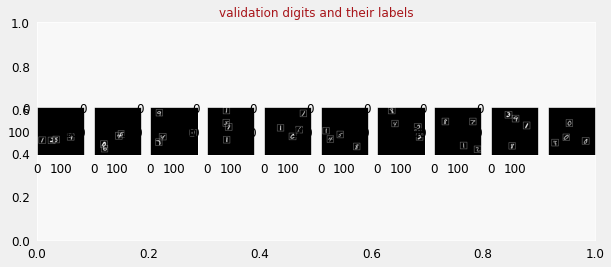

In [ ]:
display_digits_with_boxes(train_images_wcanvac,  train_bboxes, "training digits and their labels")
display_digits_with_boxes(test_images_wcanvac, test_bboxes, "validation digits and their labels")


## Writing a custom dataset

Let's write a dataset.

First, let's download and extract the data